GitHub: https://github.com/MYUSER/MYPROJECT/


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [ ]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [1]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


# Build the model

Let's define a tokenizer and read the data from disk.

In [14]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt', 'rb').read().decode().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [15]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [16]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [17]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [18]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [19]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [20]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [21]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [22]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [23]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [29]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    LSTM_model = Sequential()
    LSTM_model.add(Embedding(total_words, 128))
    LSTM_model.add(LSTM(units=128))
    LSTM_model.add(Dense(total_words, activation='softmax'))
    LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return LSTM_model

#Print details of the model.
model = deep_fake_comment_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         160896    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1257)              162153    
Total params: 454,633
Trainable params: 454,633
Non-trainable params: 0
_________________________________________________________________


Now, let's start our training.

In [30]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Train on 4030 samples
Epoch 1/200
4030/4030 [==============================] - 5s 1ms/sample - loss: 6.3680 - accuracy: 0.0655
Epoch 2/200
4030/4030 [==============================] - 3s 833us/sample - loss: 5.8735 - accuracy: 0.0734
Epoch 3/200
4030/4030 [==============================] - 3s 857us/sample - loss: 5.7204 - accuracy: 0.0933
Epoch 4/200
4030/4030 [==============================] - 4s 898us/sample - loss: 5.5450 - accuracy: 0.1176
Epoch 5/200
4030/4030 [==============================] - 4s 896us/sample - loss: 5.3389 - accuracy: 0.1367
Epoch 6/200
4030/4030 [==============================] - 4s 906us/sample - loss: 5.1380 - accuracy: 0.1546
Epoch 7/200
4030/4030 [==============================] - 4s 926us/sample - loss: 4.9502 - accuracy: 0.1653
Epoch 8/200
4030/4030 [==============================] - 4s 938us/sample - loss: 4.7674 - accuracy: 0.1747
Epoch 9/200
4030/4030 [==============================] - 4s 972us/sample - loss: 4.5918 - accuracy: 0.1878
Epoch 10/200
4030

4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1758 - accuracy: 0.9479
Epoch 78/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1719 - accuracy: 0.9489
Epoch 79/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1682 - accuracy: 0.9486
Epoch 80/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1673 - accuracy: 0.9471
Epoch 81/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1649 - accuracy: 0.9491
Epoch 82/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1625 - accuracy: 0.9491
Epoch 83/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1600 - accuracy: 0.9489
Epoch 84/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1594 - accuracy: 0.9494
Epoch 85/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1567 - accuracy: 0.9494
Epoch 86/200
4030/4030 [==============================] - 4

4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1266 - accuracy: 0.9501
Epoch 154/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1283 - accuracy: 0.9504
Epoch 155/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1324 - accuracy: 0.9504
Epoch 156/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1855 - accuracy: 0.9382
Epoch 157/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1483 - accuracy: 0.9459
Epoch 158/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1330 - accuracy: 0.9501
Epoch 159/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1285 - accuracy: 0.9501
Epoch 160/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1273 - accuracy: 0.9496
Epoch 161/200
4030/4030 [==============================] - 4s 1ms/sample - loss: 0.1268 - accuracy: 0.9499
Epoch 162/200
4030/4030 [==========================

Let's plot details of our training.

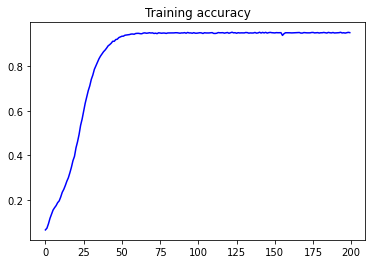

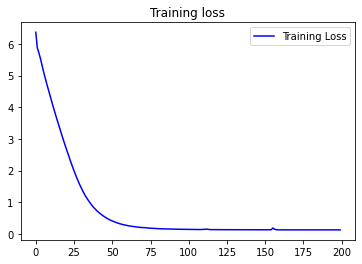

In [31]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [32]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    for i in range(max_sequence_len):
        
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len, padding='pre'))
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ''
        for index,word in reverse_word_map.items():
            if predicted == index:
                output_word = word
        seed_text = seed_text + " " + output_word
        
        if '.' in seed_text:
            break
            
    return seed_text


**Let's test it:**

In [33]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))
print(generate("China has"))


COVID19 virus cannot be transmitted in areas with hot and humid climates .
COVID19 is the deadliest virus known to humans .
The usa is florida has announced measures that all workplaces with 10 employees or more are to have paid mandatory leave to avoid the spread of covid19 coronavirus starting on march 6 , 2020 .
The new virus causes covid19 virus was created was ‘funded' by president barak sp hussein obama in 2015 to the tune of 3 , 800 , 000 american dollars ! besides us , israel best at inventions judaism , olives .
China has died from the flu this year are just an advance on your next tax return .


**Let's test it in an interactive mode:**

In [38]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: I have won a Noble price
I have won a Noble price , this guy died twice ! economy even stronger now ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! means symptoms garlic check ? 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [39]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
    for i in range(max_sequence_len):

        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len, padding='pre'))
        
        predicted = model.predict_proba(token_list, verbose=0)

        predicted_1D = predicted.reshape(1257,)
        
        random_token = np.random.choice(predicted_1D)

        index_predicted = np.where(predicted_1D == random_token)
        
        output_word = ''
        
        for index,word in reverse_word_map.items():
            if index_predicted[0] == index:
                output_word = word
    
        seed_text = seed_text + " " + output_word
        
        if '.' in seed_text:
            break    

    return seed_text

**Let's test it in an interactive mode:**

In [41]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate_sample(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: I am the most handsome man around the world
I am the most handsome man around the world americans orders calling caused lose governmentreopened lot hoax research months executive doesn't super already saying mortality drinking kills gets chinese peace days steam cattle entitled essentially tom gay already shares why leave behind reason emergency mutated ventilators expired solution year in home supplier treating 16 suits just saying pay inhale bleach one's clorox cocaine remains ‘i election located important discomfort we're 

# Generate your own text 

Below, use you own data to generate content for a different application:

# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

